In [1]:
import os
import sys
path = '../'
sys.path.insert(1, '{0}/pkg/'.format(path))
import SpikeSuMM_utils as utils
import matplotlib.pyplot as plt
import warnings
import tqdm
import pickle
# import pickle5 as pickle
import torch
import full_network as network
import numpy as np
warnings.filterwarnings("ignore")
outputfile = open('logs_single_run.txt', "w")
outputfile.close()

In [2]:
deter_start = None
number_rooms = 16
n_moves = 2
n_maze = 2
volatility = 0.002
epochs = 10000
batch_size = 1
seed = 1

In [3]:
simulation = utils.create_simulation(epochs = epochs, number_rooms = number_rooms, volatility = volatility
         , n_moves = n_moves, n_maze = n_maze, seed  = seed, Dirichlet = 0,deter_start = deter_start,symmetric = True)

In [4]:
def one_hot(x):
    h = torch.zeros(number_rooms)
    h[x]=1
    return h
def modulation(x,params,type_ = 'normal'):
    if type_ == 'normal':
        return params['0'] * torch.tanh(x) + params['1'] * torch.tanh(x) * (x > params['2'])
    if type_ == 'tanh':
        return params['0'] * torch.tanh(x)
    if type_ == 'slope_tanh':
        return params['0'] * torch.tanh(params['1'] * x)
    if type_ == 'slope_normal':
        return params['0'] * torch.tanh( params['3'] * x) + params['1'] * torch.tanh( params['3'] * x) * (x > params['2'])
    if type_ == 'quadratic':
        return params['0'] * x ** 2
    if type_ == 'fix_step':
        return params['0'] + params['1'] * (x > params['2'])

In [5]:
def sim(simulation,params,type_):
    w = torch.zeros(16,16)
    erreur = []
    trans_error = []
    for epoch in range(10000):
        old, new,maze = simulation['rooms'][epoch],simulation['rooms'][epoch+1],simulation["maze"][epoch + 1]
        pred = torch.einsum(
                "ij,j->i", w, one_hot(old))
        err = pred-one_hot(new)
        error = torch.sum((err)**2)
        w -= modulation(error,params,type_) * torch.einsum(
                "i,j->ij", err, one_hot(old))
        erreur += [error]
        trans_error += [torch.sum((w-simulation["transitions"][maze])**2)]
    
    return erreur, trans_error

normal  min error: tensor(0.8653)
tanh  min error: tensor(1.1463)
slope_tanh  min error: tensor(1.2510)
slope_normal  min error: tensor(1.2060)
quadratic  min error: tensor(1.5172)
fix_step  min error: tensor(0.9072)


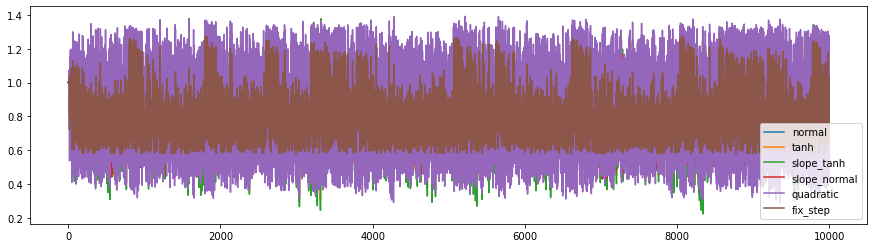

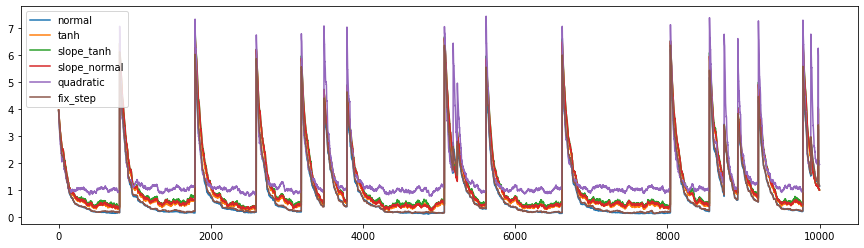

In [11]:
types = [ 'normal','tanh', 'slope_tanh','slope_normal','quadratic','fix_step']
params = [{'0':1.270e-05,'1':0.20,'2':0.8},{'0':0.132}, {'0':1e-1,'1':2},{'0':1e-5,'1':1e-1,'2':0.5,'3':2},
          {'0':0.26717091000596327},{'0':9.56e-5,'1':0.1499,'2':0.8}]
for i in range(len(types)):
    erreur, trans_error = sim(simulation,params[i],types[i])
    print(types[i],' min error:', torch.mean(torch.Tensor(trans_error)))
    
    plt.figure(1,figsize=(15,4))
    plt.plot(erreur, label=types[i])
    plt.legend()
    plt.figure(2,figsize=(15,4))
    plt.plot(trans_error, label=types[i])
    plt.legend()
plt.show()

In [12]:
min_error = 100
import skopt
import math
# warnings.filterwarnings("ignore")
def optimise_model(simulation, type_):
    write_file = 'logs/log_optimisation.txt'
    print('---------------------------START OF OPTIMIZATION--------------------------------------------------', file=open(write_file, "a"))
    global min_error
    min_error = 100
    if type_ == 'normal':
        SPACE = [
           skopt.space.Real(1e-6, 1e-4, name='0', prior='uniform'),
           skopt.space.Real(1e-4, 1, name='1', prior='uniform'),
           skopt.space.Real(0.2, 1, name='2', prior='uniform')]
    if type_ == 'tanh':
        SPACE = [
           skopt.space.Real(1e-4, 1, name='0', prior='uniform')]
    if type_ == 'slope_tanh':
        SPACE = [
           skopt.space.Real(1e-4, 1, name='0', prior='uniform'),
           skopt.space.Real(1e-2, 10, name='1', prior='uniform')]
    if type_ == 'slope_normal':
        SPACE = [
           skopt.space.Real(1e-6, 1e-4, name='0', prior='uniform'),
           skopt.space.Real(1e-4, 1, name='1', prior='uniform'),
           skopt.space.Real(0.2, 1, name='2', prior='uniform'),
           skopt.space.Real(1e-2, 10, name='3', prior='uniform')]
    if type_ == 'quadratic':
        SPACE = [
           skopt.space.Real(1e-4, 1, name='0', prior='uniform')]
    if type_ == 'fix_step':
        SPACE = [
           skopt.space.Real(1e-6, 1e-4, name='0', prior='uniform'),
           skopt.space.Real(1e-4, 1, name='1', prior='uniform'),
           skopt.space.Real(0.2, 1, name='2', prior='uniform')]
    @skopt.utils.use_named_args(SPACE)
    def objective(**params):
        
        global min_error
        all_params = {**params}
        
        _, trans_error = sim(simulation,all_params,type_)
        error = torch.mean(torch.Tensor(trans_error)).item()
        prefix ='tania_task'

        if math.isnan(error):
            error = 100
        if error < min_error:
            print(all_params)
            print(types[i],' min error:', torch.mean(torch.Tensor(trans_error)))
            min_error = error
        return error
    results = skopt.gp_minimize(objective, SPACE)
    
    

In [13]:
types = [ 'normal','tanh', 'slope_tanh','slope_normal','quadratic','fix_step']
params = [[1.270e-05,0.20,0.8],[1e-1], [1e-1,2],[1e-5,1e-1,0.5,2],[1e-1],[1e-5,1e-1,0.5]]
for i in range(len(types)):
    optimise_model(simulation,types[i])
#     erreur, trans_error = sim(simulation,params[i],)
#     plt.legend()
    
#     plt.figure(1)
#     plt.plot(erreur, label=types[i])
#     plt.legend()
#     plt.figure(2)
#     plt.plot(trans_error, label=types[i])
#     plt.legend()
# plt.show()

{'0': 7.557697180370879e-05, '1': 0.9660664584920884, '2': 0.48533394463675755}
normal  min error: tensor(9.7464)
{'0': 6.460818560950077e-05, '1': 0.4393981604105211, '2': 0.27819340235459566}
normal  min error: tensor(2.1326)
{'0': 9.972473088319241e-05, '1': 0.48439467136018904, '2': 0.8218377360979361}
normal  min error: tensor(1.7546)
{'0': 2.402719637088116e-05, '1': 0.436100356064598, '2': 0.9718096093256732}
normal  min error: tensor(1.3345)
{'0': 8.821958339027736e-05, '1': 0.15574347660623977, '2': 0.2}
normal  min error: tensor(1.1560)
{'0': 7.595481248882615e-05, '1': 0.1397772020216251, '2': 0.4001355460770502}
normal  min error: tensor(1.1441)
{'0': 7.413010309809093e-05, '1': 0.13909469250858766, '2': 0.40869848965542527}
normal  min error: tensor(1.1433)
{'0': 4.4752838595829816e-05, '1': 0.16237519368261, '2': 0.8148171793882297}
normal  min error: tensor(0.9047)
{'0': 4.465030215535347e-05, '1': 0.17400667532437408, '2': 0.8110271093884467}
normal  min error: tensor(0